# $K_{sp}$ values

calcite

$$ \mathrm{CaCO_3}_{(\mathrm{s})} = \mathrm{Ca^{2+}} + \mathrm{CO_3^{2-}}$$

$$K_{sp} = [\mathrm{Ca^{2+}}][\mathrm{CO_3^{2-}}]=3.4e-9$$

portlandite.  

$$ \mathrm{Ca(OH)_2}_{(\mathrm{s})} = \mathrm{Ca^{2+}} + 2\mathrm{OH^{-}}$$

$$K_{sp} = [\mathrm{Ca^{2+}}][\mathrm{OH^{-}}]^2=5.5e-6$$

amorphous silica

$$ \mathrm{Si(O)_2}_{(\mathrm{s})} + 2H_2O= \mathrm{H_4SiO_4}$$

$$K_{sp} = [\mathrm{H_4SiO_2}]=10^{-3.02}$$

CO2 gas

$$ \mathrm{CO_2}_{(\mathrm{g})} + H_2O= \mathrm{H_2CO_3}$$

$$K_{sp} = [\mathrm{H_2CO_3}]=10^{-1.47}\times 10^{-3.5} = 10^{-4.97}$$



In [1]:
% clear the space

clear

% input constants

KspC=3.4e-9; KspP=5.5e-6; PCO2=10^-3.5; KH=10^-1.47; KspCO2=PCO2*KH;
Ka1=10^-6.3; Ka2=10^-10.3; Kw=1e-14; KspQ=10^-3.02; Ka1Q=10^-9.84; Ka2Q=10^-13.2;
Kw=1e-14; KspC=3.4e-9; KspC=1.4e-8; KspP=5.5e-6; 
kC=1e-5; kP=8e-4; kQ=1e-4; kCO2=1e-8;

# Simple kinetic model for precipitaton/dissolution

There are some variations of this but in a simple way the rate of dissolution of a mineral can be written [Mdamba et al. (2015)](https://pubmed.ncbi.nlm.nih.gov/25462741/)

$$\dfrac{d(mineral)}{dt} = k\left(\dfrac{IAP}{Ksp}-1\right)$$

You can see if IAP/Ksp is undersaturated (less than 1) the rate will be negative indicating dissolution.

if IAP/Ksp is supersaturated (greater than one) then the rate will be positive indicating precipitation.

if IAP/Ksp is one then the rate will be zero and the system is at equilibrium.

[PHREEQC Rate Expression](https://wwwbrr.cr.usgs.gov/projects/GWC_coupled/phreeqc/html/final-20.html)

The expression can be written including a term for the precipitated amount of solid X that will speed up precipitation (seed crystals to grow on) and exponents to modify the rates ...

$$\dfrac{d(mineral)}{dt} = k X \left(\left(\dfrac{IAP}{Ksp}\right)^m-1\right)^n$$

We can implement such reactions into Octave using the ODE solver.   et's define the function for the dissolution of portlandite.  First put in a function to return the speciation when [calcium] is known (function [H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(Ca,Kw,KH,Ka1,Ka2,PCO2)).  Then put in the ODE as follows:

$$\dfrac{d(portlandite)}{dt} = k_P X_P \left(\left(\dfrac{IAP_P}{Ksp_P}\right)^m-1\right)^n$$
$$\dfrac{d(calcite)}{dt} = k_C X_C \left(\left(\dfrac{IAP_C}{Ksp_C}\right)^p-1\right)^q$$
$$\dfrac{d([Ca])}{dt} = -k_P X_P \left(\left(\dfrac{IAP_P}{Ksp_P}\right)^p-1\right)^q - k_C X_C \left(\left(\dfrac{IAP_C}{Ksp_C}\right)^m-1\right)^n$$

start with $m$ and $n$ and $p$ and $q$ equal to 1.

add two more equations.  loss of SiO2 and gain of H4SiO4.

$$\dfrac{d(quartz)}{dt} = k_Q X_Q \left(\left(\dfrac{IAP_Q}{Ksp_Q}\right)-1\right)$$

$$\dfrac{d([H2SiO4])}{dt} = -k_Q X_Q \left(\left(\dfrac{IAP_Q}{Ksp_Q}\right)-1\right)$$

and one more equations for CO2 (consider atmosphere reservoir as infinite) so just gain of H2CO3 (so no X term).

$$\dfrac{d([H2CO3])}{dt} = -k_{CO2}\left(\left(\dfrac{[H2CO3]}{Ksp_{CO2}}\right)-1\right)$$



In [2]:
function [H,OH,HCO3,CO3,HSiO4,SiO4]=CO2SiO2Caspeciesopen(Ca,H2SiO4,H2CO3,Kw,Ka1,Ka2,Ka1Q,Ka2Q)

a=1; b=2*Ca; c=-Ka1*H2CO3-Kw-Ka1Q*H2SiO4; d=-2*Ka2*Ka1*H2CO3-2*Ka1Q*Ka2Q*H2SiO4;
H=roots([a b c d]);
H=H(imag(H)==0); %sets any imaginary roots to zero
% display the positive real root
H=H(H>0);
% display the logical real root
% never going to get pH super low
%H=H(H<1);
%solve speciation
HCO3=(H2CO3*Ka1)/H; CO3=(H2CO3*Ka1*Ka2)/(H^2); OH=Kw/H;
HSiO4=(H2SiO4*Ka1Q)/H; SiO4=(H2SiO4*Ka1Q*Ka2Q)/(H^2);
chargecheck=2*Ca+H-OH-HCO3-HSiO4-2*SiO4-2*CO3;
end

In [3]:
% try with ode solver.  first need to define the function

function dCdt=dC_by_dt(t,C,Kw,KH,Ka1,Ka2,PCO2,KspC,KspP,KspCO2,KspQ,kC,kP,kQ,kCO2,Ka1Q,Ka2Q)

port=C(1); calcite=C(2); Ca=C(3); Quartz=C(4); H2SiO4=C(5); H2CO3=C(6);

[H,OH,HCO3,CO3,HSiO4,SiO4]=CO2SiO2Caspeciesopen(Ca,H2SiO4,H2CO3,Kw,Ka1,Ka2,Ka1Q,Ka2Q);

IAPP=Ca*OH^2; IAPC=Ca*CO3; IAPQ=[H2SiO4]; IAPCO2=[H2CO3];

dCdt=zeros(6,1); % set to zeros initially

% the three entries for the 3 rates. 

%rate of decrease in portlandite concentration.  IAP/Ksp is less than 1 so rate is negative
dCdt(1)=kP*port*(IAPP/KspP-1);  

%rate of formation of calcite
if IAPC/KspC >1; dCdt(2)=calcite*kC*(((IAPC/KspC-1))); end

%rate of increase in calcium concentration from port dissolve and decrease Ca from calcite ppte
dCdt(3)=-kP*port*(IAPP/KspP-1)-calcite*kC*(IAPC/KspC-1);  

dCdt(4)=kQ*Quartz*(IAPQ/KspQ-1);  
dCdt(5)=-kQ*Quartz*(IAPQ/KspQ-1);  
dCdt(6)=-kCO2*(IAPCO2/KspCO2-1);  

dC=dCdt;

end

In [4]:
% make an anonymous function because ODE solver only wants conc and time as variables
% and dfine all the constants too

dCdtrate = @(t,C)dC_by_dt(t,C,Kw,KH,Ka1,Ka2,PCO2,KspC,KspP,KspCO2,KspQ,kC,kP,kQ,kCO2,Ka1Q,Ka2Q);


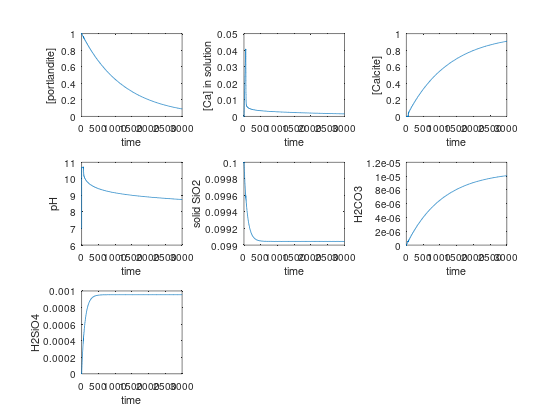

In [5]:
% call ODE solver
% initial conditions
port=1; calcite=1e-9; Ca=0; Quartz=0.1; H2SiO4=1e-9; H2CO3=1e-9;

C=[port calcite Ca Quartz H2SiO4 H2CO3];

%[t, C]=ode45(dCdtrate,[0 5],C);
%[t, C]=ode15s(dCdtrate,[0 430],C); 
[t, C]=ode23s(dCdtrate,[0 3000],C); 

port=C(:,1); calcite=C(:,2); Ca=C(:,3); Quartz=C(:,4); H2SiO4=C(:,5); H2CO3=C(:,6);

for i=1:length(Ca)
    [H,OH,HCO3,CO3,HSiO4,SiO4]=CO2SiO2Caspeciesopen(Ca(i),H2SiO4(i),H2CO3(i),Kw,Ka1,Ka2,Ka1Q,Ka2Q);
    pH(i)=-log10(H);
end

subplot(331); plot(t,port); ylabel('[portlandite]'); xlabel('time')
subplot(332); plot(t,Ca); ylabel('[Ca] in solution'); xlabel('time')
subplot(333); plot(t,calcite); ylabel('[Calcite]'); xlabel('time')
subplot(334); plot(t,pH); ylabel('pH'); xlabel('time')
subplot(335); plot(t,Quartz); ylabel('solid SiO2'); xlabel('time')
subplot(336); plot(t,H2CO3); ylabel('H2CO3'); xlabel('time')
subplot(337); plot(t,H2SiO4); ylabel('H2SiO4'); xlabel('time')
